## 库函数与训练数据的加载

In [1]:
# 导入实验所需的相关库函数
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

D:\product_app\py_venvs\work_internship\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'D:\product_app\py_venvs\work_internship\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 下载实验所需的MNIST数据集
train_dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

# 查看mnist数据
print(train_dataset)

# 查看是否支持cuda GPU训练
print(torch.cuda.is_available())

# 数据集切分
batch_size = 128
dataIter = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
True


## 代价损失函数：通过俩种不同的方式构建损失函数

In [3]:
# 展平：多维数据展平成低维数据
def flatten(x):
    N = x.shape[0]  # read in N, C, H, W
    return x.view(N, -1)  # torch.Size([128, 784])


# L2损失 (MSE Loss) 构建损失函数
def vae_loss_mse(x, gen_x, mean, log_var):
    # 重构项损失
    mse_loss = torch.nn.MSELoss(reduction='sum')
    loss1 = mse_loss(gen_x, x)

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss


# 交叉熵损失 (Cross Entropy Loss) 构建损失函数
def vae_loss_cross(x, gen_x, mean, log_var):
    # 重构项损失
    loss1 = F.binary_cross_entropy(gen_x, x, reduction='sum')

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss

## 构造网络模型
- 采用全连接Dense(Linear)设计网络架构
- 采用卷积层Conv+Dense设计网络架构

### 全连接层——VAE网络

In [4]:
class VariationalAutoEncoder_Dense(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 dense_size=(784, 256, 128),
                 z_dim=20):
        super(VariationalAutoEncoder_Dense, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])
        self.enDense1 = nn.Linear(dense_size[1], dense_size[2])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], dense_size[-3])

        # decoder reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 展平
        out = flatten(x)
        # 全连接层
        out = self.relu(self.enDense0(out))
        out = self.relu(self.enDense1(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

### 卷积层——VAE网络

In [5]:
class VariationalAutoEncoder_Conv(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 conv_size=(1, 6, 16, 4),
                 dense_size=(784, 128),
                 kernel=3,
                 z_dim=20):
        super(VariationalAutoEncoder_Conv, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder卷积层
        # 输入 (128,1,28,28) 输出 (128,6,28,28)
        self.enConv0 = nn.Conv2d(conv_size[0], conv_size[1], kernel, padding=1, padding_mode='replicate')
        # 输入 (128,6,28,28) 输出 (128,16,14,14)
        self.enConv1 = nn.Conv2d(conv_size[1], conv_size[2], kernel, stride=2, padding=1, padding_mode='replicate')
        # 输入 (128,16,14,14) 输出 (128,4,14,14)
        self.enConv2 = nn.Conv2d(conv_size[2], conv_size[3], kernel, padding=1, padding_mode='replicate')

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], int(np.prod(image_shape)))

        # 需要对 全连接层输出的一维结果数据 进行 reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 卷积层
        out = self.relu(self.enConv0(x))
        out = self.relu(self.enConv1(out))
        out = self.relu(self.enConv2(out))

        # 展平
        out = flatten(out)

        # 全连接层
        out = self.relu(self.enDense0(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

## 查看网络结构

In [6]:
# 网络训练设备：建议使用cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 利用summary函数查看网络的层次结构
print("==========================VAE(Dense)网络结构==========================")
model_Dense = VariationalAutoEncoder_Dense()
model_Dense.to(device)
summary(model_Dense, input_size=(1, 28, 28))
print("==========================VAE(Conv)网络结构==========================")
model_Conv = VariationalAutoEncoder_Conv()
model_Conv.to(device)
summary(model_Conv, input_size=(1, 28, 28))

==========================VAE(Dense)网络结构==========================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 20]           2,580
            Linear-6                   [-1, 20]           2,580
            Linear-7                  [-1, 128]           2,688
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 784]         201,488
          Sigmoid-12                  [-1, 784]               0
Total params: 476,216
Trainable para

## 设定模型参数

In [7]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型 二选一 即可
model = model_Conv
# model = model_Dense

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 模型训练

In [8]:
train_loss = []  # 保存每个epoch的训练误差
number = len(dataIter.dataset)
result_dir = './VAEResult'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = vae_loss_mse(x, gen_x, mean, log_var)
        # loss = vae_loss_cross(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        # 输出batch信息
        if i % 100 == 0 and i > 0:
            print("epoch : {0} | batch : {1} | batch average loss: {2}"
                  .format(epoch + 1, i, loss.item() / x.shape[0]))

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])
        #     save_image(x_concatD, './%s/reconstructed-%d.png' % (result_dir, epoch + 1))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

epoch : 1 | batch : 100 | batch average loss: 53.508697509765625
epoch : 1 | batch : 200 | batch average loss: 52.55126953125
epoch : 1 | batch : 300 | batch average loss: 51.36144256591797
epoch : 1 | batch : 400 | batch average loss: 42.50716781616211
epoch[1/10] | loss:51.29273671875
epoch : 2 | batch : 100 | batch average loss: 36.90682601928711
epoch : 2 | batch : 200 | batch average loss: 38.663658142089844
epoch : 2 | batch : 300 | batch average loss: 33.62120819091797
epoch : 2 | batch : 400 | batch average loss: 33.37281036376953
epoch[2/10] | loss:36.09513554280599
epoch : 3 | batch : 100 | batch average loss: 34.294925689697266
epoch : 3 | batch : 200 | batch average loss: 33.40984344482422
epoch : 3 | batch : 300 | batch average loss: 32.704254150390625
epoch : 3 | batch : 400 | batch average loss: 31.101463317871094
epoch[3/10] | loss:32.97938513997396
epoch : 4 | batch : 100 | batch average loss: 31.242280960083008
epoch : 4 | batch : 200 | batch average loss: 33.05007934

## 展示最终迭代训练后：VAE生成图片与原始图片的对比

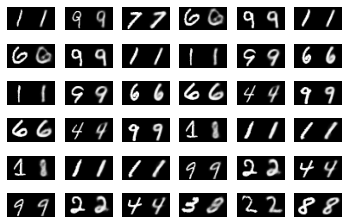

In [9]:
# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

## evaluation 测试生成效果

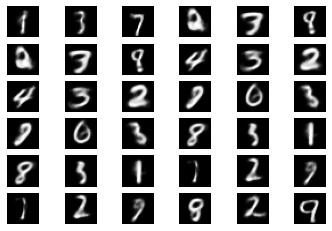

In [10]:
# 从正态分布随机采样z
z = torch.randn((batch_size, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.
# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

## 隐变量输出展示
### 为了便于得知隐变量的学习内容，将z_dim改成2维，进行训练学习，观察隐变量采样

epoch[1/15] | loss:49.43062805582682
epoch[2/15] | loss:41.87694946289062
epoch[3/15] | loss:40.57637614746094
epoch[4/15] | loss:39.69094854329427
epoch[5/15] | loss:39.034717643229165
epoch[6/15] | loss:38.502320267740885
epoch[7/15] | loss:38.13409830322266
epoch[8/15] | loss:37.80903264160156
epoch[9/15] | loss:37.5437287882487
epoch[10/15] | loss:37.34698892822266
epoch[11/15] | loss:37.15285506998698
epoch[12/15] | loss:37.0216513264974
epoch[13/15] | loss:36.844077294921874
epoch[14/15] | loss:36.71782579345703
epoch[15/15] | loss:36.61701103108724


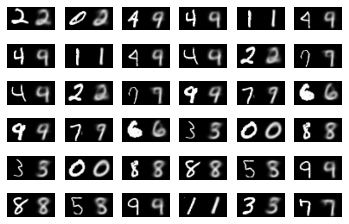

In [11]:
import os
from scipy.stats import norm

# 生成隐空间内的采样
# 训练时Z_dim设定为20，这里仅观察隐空间前俩维度表示特征
model = VariationalAutoEncoder_Conv(z_dim=2)
model.to(device)
epoches = 15
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []  # 保存每个epoch的训练误差
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = vae_loss_mse(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

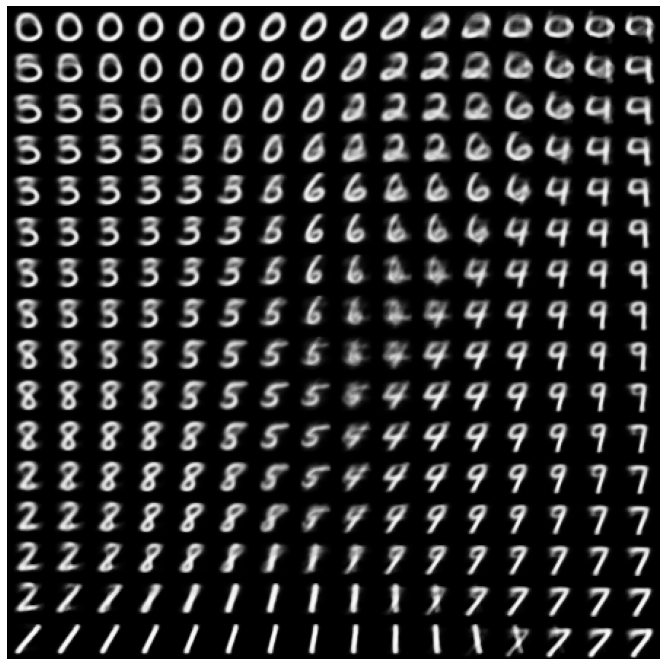

In [12]:
num_per_row, num_per_col = 16, 16
digit_size = 28
figure = np.zeros((digit_size * num_per_row, digit_size * num_per_col))
grid_x = norm.ppf(np.linspace(0.05, 0.95, num_per_row))
grid_y = norm.ppf(np.linspace(0.05, 0.95, num_per_col))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.tensor(np.tile(z_sample, batch_size).reshape(batch_size, 2)).to(device).to(torch.float32)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        digit = torch.sigmoid(digit)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit.detach().cpu().numpy() * 255.

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()

### 从上图中可以看出，VAE学到的二维隐变量Z:
- 第一维度（竖直维度）主要控制`数字的形状`，字体的斜度改变幅度不大
- 第二维度（水平维度）主要控制数字的`倾斜`和`形状（低于第一维度的影响）`

## 引入CVAE
### 先介绍AE和VAE的优缺点：
- AE适合数据压缩与还原，不适合生成未见过的数据
- VAE适合生成未见过的数据，但不能控制生成内容。
### CVAE（Conditional VAE）可以在生成数据时通过指定其标签来生成想生成的数据

<img src="https://img2020.cnblogs.com/blog/2226924/202104/2226924-20210424093924301-1328423376.jpg"  alt="ImageFile" style="zoom:50%;"/>


In [13]:
# 条件变分自编码器
class CVAE(nn.Module):

    def __init__(self, feature_size, class_size, latent_size):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(feature_size + class_size, 200)
        self.fc2_mu = nn.Linear(200, latent_size)
        self.fc2_log_std = nn.Linear(200, latent_size)
        self.fc3 = nn.Linear(latent_size + class_size, 200)
        self.fc4 = nn.Linear(200, feature_size)

    def encode(self, x, y):
        h1 = F.relu(self.fc1(torch.cat([x, y], dim=1)))  # 连接特征和标签
        mu = self.fc2_mu(h1)
        log_std = self.fc2_log_std(h1)
        return mu, log_std

    def decode(self, z, y):
        h3 = F.relu(self.fc3(torch.cat([z, y], dim=1)))  # 连接标签和latent隐变量
        recon = torch.sigmoid(self.fc4(h3))
        return recon

    def reparametrize(self, mu, log_std):
        std = torch.exp(0.5 * log_std)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, y):
        mu, log_std = self.encode(x, y)
        z = self.reparametrize(mu, log_std)
        recon = self.decode(z, y)
        return recon, mu, log_std

    def loss_function(self, recon, x, mu, log_std) -> torch.Tensor:
        recon_loss = F.mse_loss(recon, x, reduction="sum")
        kl_loss = -0.5 * (1 + 2 * log_std - mu.pow(2) - torch.exp(2 * log_std))
        kl_loss = torch.sum(kl_loss)
        loss = recon_loss + kl_loss
        return loss

In [29]:
cvae = CVAE(feature_size=784, class_size=10, latent_size=20)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)
result_dir = 'D:\\PycharmProjects\\pyProject\\NKU_ML\\VAEResult\\CVAE'

train_loss = []
epoches = 40
for epoch in range(epoches):

    batch_loss = []
    for i, data in enumerate(dataIter):
        img, label = data
        img.to(device)
        inputs = img.view(img.shape[0], -1)
        y = torch.nn.functional.one_hot(label, num_classes=10)
        # print(inputs.shape)
        # print(y.shape)
        y.to(device)

        recon, mu, log_std = cvae(inputs, y)
        loss = cvae.loss_function(recon, inputs, mu, log_std)
        batch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 输出batch信息
        if i % 100 == 0 and i > 0:
            print("epoch : {0} | batch : {1} | batch average loss: {2}"
                  .format(epoch + 1, i, loss.item() / img.shape[0]))
        if i == 0:
            x_concatD = torch.cat([img.view(-1, 1, 28, 28), recon.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concatD, '%s\\reconstructed-%d.png' % (result_dir, epoch + 1))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

epoch : 1 | batch : 100 | batch average loss: 50.752933502197266
epoch : 1 | batch : 200 | batch average loss: 43.912479400634766
epoch : 1 | batch : 300 | batch average loss: 39.983821868896484
epoch : 1 | batch : 400 | batch average loss: 38.1992301940918
epoch[1/40] | loss:48.86708398030599
epoch : 2 | batch : 100 | batch average loss: 37.0618896484375
epoch : 2 | batch : 200 | batch average loss: 35.636844635009766
epoch : 2 | batch : 300 | batch average loss: 38.33842468261719
epoch : 2 | batch : 400 | batch average loss: 36.176387786865234
epoch[2/40] | loss:36.426066800944014
epoch : 3 | batch : 100 | batch average loss: 37.01198196411133
epoch : 3 | batch : 200 | batch average loss: 32.852603912353516
epoch : 3 | batch : 300 | batch average loss: 35.55483627319336
epoch : 3 | batch : 400 | batch average loss: 35.558929443359375
epoch[3/40] | loss:34.440828385416665
epoch : 4 | batch : 100 | batch average loss: 33.00487518310547
epoch : 4 | batch : 200 | batch average loss: 34.4

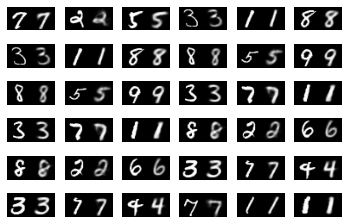

In [30]:
# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

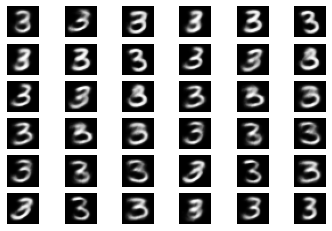

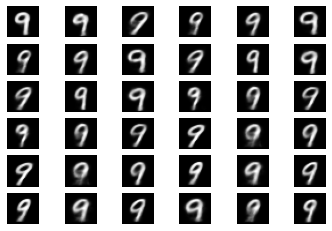

In [31]:
# 利用CVAE生成特定label下的图片
label = 3
z = torch.randn(784, 20)
labels = torch.full(size=(784,), fill_value=label, dtype=torch.int64)
y = torch.nn.functional.one_hot(labels, num_classes=10)
recon = cvae.decode(z, y)

# 显示
img = recon.view(recon.shape[0],  28, 28).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(img[i * 3 + j], cmap='gray')
plt.show()

label = 9
z = torch.randn(784, 20)
labels = torch.full(size=(784,), fill_value=label, dtype=torch.int64)
y = torch.nn.functional.one_hot(labels, num_classes=10)
recon = cvae.decode(z, y)

# 显示
img = recon.view(recon.shape[0],  28, 28).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(img[i * 3 + j], cmap='gray')
plt.show()